In [1]:
import imageio
import imgaug as ia
from imgaug.augmentables.polys import Polygon, PolygonsOnImage
import imgaug.augmenters.flip as flip

import numpy as np
import pyclipper
import shapely
from shapely.geometry import Polygon as sPolygon
from shapely.geometry import Point,LineString,LinearRing
import matplotlib.pyplot as plt
import cv2 as cv

(array([388, 389, 390, ..., 408, 409, 410], dtype=int64),
 array([ 70,  70,  70, ..., 465, 465, 465], dtype=int64))

(27824,)


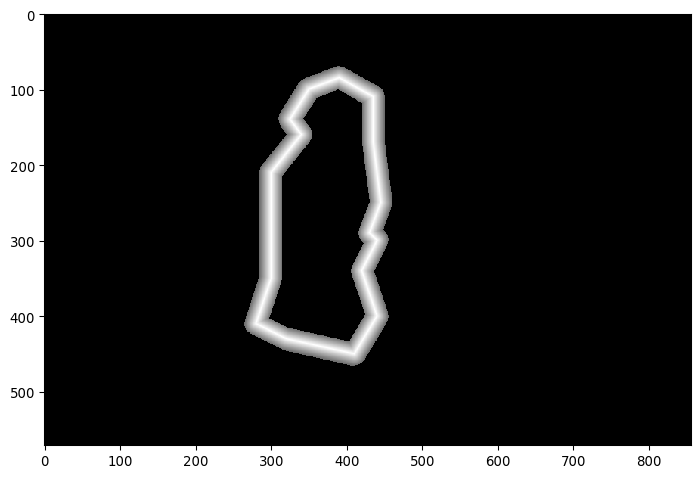

In [10]:
gt = [
        (350, 100),  # top left
        (390, 85),  # top
        (435, 110),  # top right
        (435, 170),
        (445, 250),  # right elbow
        (430, 290),  # right hip
        (440, 300),
        (420, 340),
        (440, 400),
        (410, 450),  # right foot
        (320, 430),
        (280, 410),  # left foot
        (300, 350),
        (300, 210),  # left elbow
        (340, 160),
        (325, 140)  # nose
    ]

poly_gt = Polygon(gt)

pco = pyclipper.PyclipperOffset()
pco.AddPath(gt, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
solution = pco.Execute(-15.0)
solution = np.array(solution)  
solution = np.squeeze(solution)
p_new1 = Polygon(solution)

pco.AddPath(gt, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
solution = pco.Execute(15.0)
solution = np.array(solution)
solution = np.squeeze(solution)
p_new2 = Polygon(solution)

image = imageio.imread("1.jpg")
seg_map = np.zeros((image.shape[0],image.shape[1]))
seg_map = cv.fillPoly(seg_map,[p_new2.coords.astype(np.int32)],1)
seg_map = cv.fillPoly(seg_map,[p_new1.coords.astype(np.int32)],0)

# ia.imshow(seg_map)
# ia.imshow(poly_gt.draw_on_image(image, alpha_face=0.2, size_points=7))

ys,xs = np.nonzero(seg_map)
xs,ys

poly_gt = poly_gt.to_shapely_line_string(closed=True)

def cal_distance(x,y):
    return Point(x,y).distance(poly_gt)

def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

func_cal_distance = np.frompyfunc(cal_distance, 2, 1)
dis_map = func_cal_distance(xs,ys)
dis_map = np.clip(dis_map / 15, 0, 1)
dis_map = dis_map*0.4+0.3
dis_map = 1-dis_map


print(dis_map.shape)

th_map = np.zeros((image.shape[0],image.shape[1]))
th_map[ys,xs] = dis_map

ia.imshow(th_map)

In [ ]:
# image = imageio.imread("https://upload.wikimedia.org/wikipedia/commons/9/9a/Meerkat_%28Suricata_suricatta%29_Tswalu.jpg")
# image = ia.imresize_single_image(image, 0.25)
# print(image.shape)
# ia.imshow(image)